In [1]:
from fastai.vision.all import *
import fastai
import timm
from wwf.vision.timm import *
import pandas as pd

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('data/wheat_new.csv',decimal=',')

In [4]:
df

,Unnamed: 0,file,DAS,plot nº,photo nº,species,water_treatment,management,plot m2,avg_water (L m-2),...,P (kg microplot-1),K (kg microplot-1),avg_height,GA,GGA,CSI,NGRDIveg,TGIveg,final yield (kg),dataset
0,0,20220517_1 (1).JPG,96,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.959407,0.904393,5.734098,0.1324,2569.2709,9.15,train
1,1,20220517_1 (2).JPG,96,1,(2).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.963030,0.905523,5.971505,0.1316,2648.0105,9.15,train
2,2,20220517_1 (3).JPG,96,1,(3).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.953708,0.898722,5.765430,0.1331,2736.4337,9.15,train
3,3,20220517_1 (4).JPG,96,1,(4).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.957117,0.898772,6.095965,0.1267,2550.8238,9.15,train
4,4,20220602_1 (1).JPG,112,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.892348,0.791199,11.335180,0.1008,1880.2128,9.15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,20220615_25 (4).JPG,125,25,(4).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.788544,0.323428,58.984136,0.0491,2277.6824,7.95,test
252,252,20220701_25 (1).JPG,141,25,(1).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.031868,0.009072,71.532905,0.0342,946.1760,7.95,test
253,253,20220701_25 (2).JPG,141,25,(2).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.025828,0.006849,73.483356,0.0314,867.4491,7.95,test
254,254,20220701_25 (3).JPG,141,25,(3).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.022065,0.004773,78.367629,0.0196,855.3556,7.95,test


In [5]:
np.unique(df['management'])

array(['conv', 'eco'], dtype=object)

In [6]:
dftrain = df[(df.dataset=='train')|(df.dataset=='validation')]
dftrain.loc[:,'dataset'] =  dftrain['dataset'].apply(lambda x: x=='validation')
df.loc[:,'dataset'] =  df['dataset'].apply(lambda x: x=='test')

In [7]:
dftrain.columns

Index(['Unnamed: 0', 'file', 'DAS', 'plot nº', 'photo nº', 'species',
       'water_treatment', 'management', 'plot m2', 'avg_water (L m-2)',
       'N (kg microplot-1)', 'P (kg microplot-1)', 'K (kg microplot-1)',
       'avg_height', 'GA', 'GGA', 'CSI', 'NGRDIveg', 'TGIveg',
       'final yield (kg)', 'dataset'],
      dtype='object')

In [8]:
db = DataBlock(blocks = (ImageBlock,
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock(),
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock(),
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/')],
                 get_y=[#ColReader('species'),
                        #ColReader('water_treatment'),
                        #ColReader('management'),
                        ColReader('plot m2'),
                        ColReader('avg_water (L m-2)'),
                        ColReader('N (kg microplot-1)'),
                        ColReader('P (kg microplot-1)'),
                        ColReader('K (kg microplot-1)'),
                        ColReader('avg_height'),
                        ColReader('GA'),
                        ColReader('GGA'),
                        ColReader('CSI'),
                        ColReader('NGRDIveg'),
                        ColReader('TGIveg'),
                        ColReader('final yield (kg)')],
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(640),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)],
               n_inp=1)
dls = db.dataloaders(dftrain,bs=4)

In [9]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='volo_yield_all_plain_output'),
    ReduceLROnPlateau()
]

In [10]:
class MultiInputModel(Module):
  "A three-headed model given a `body` and `n` output features"
  def __init__(self, body:nn.Sequential):
    nf = num_features_model(nn.Sequential(*body.children()))
    self.body = body
    #self.water_treatment = create_head(nf, 4)
    #self.management = create_head(nf, 2)
    self.avg_water = create_head(nf,1)
    self.n = create_head(nf,1)
    self.p = create_head(nf,1)
    self.k = create_head(nf,1)
    self.avg_height = create_head(nf,1)
    self.ga = create_head(nf,1)
    self.gga = create_head(nf,1)
    self.csi = create_head(nf,1)
    self.NGRDIveg = create_head(nf,1)
    self.TGIveg = create_head(nf,1)
    self.yieldprod = create_head(nf,1)

    
    
  
  def forward(self, x):
    y = self.body(x)
    return [
        #self.water_treatment(y),
        #self.management(y),
        self.avg_water(y),
        self.n(y),
        self.p(y),
        self.k(y),
        self.avg_height(y),
        self.ga(y),
        self.gga(y),
        self.csi(y),
        self.NGRDIveg(y),
        self.TGIveg(y),
        self.yieldprod(y)]

In [11]:
body = create_timm_body('volo_d2_384', pretrained=True)
# body = create_body(resnet50, pretrained=True)
net = MultiInputModel(body)

Downloading: "https://github.com/sail-sg/volo/releases/download/volo_1/d2_384_86.0.pth.tar" to /home/ancasag/.cache/torch/hub/checkpoints/d2_384_86.0.pth.tar


In [12]:
from fastai.metrics import mae,rmse,mse

In [13]:
class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    def __init__(self, func1=F.cross_entropy,func2=F.mse_loss, weights=[2, 1]):
        self.func1, self.func2, self.w = func2, func2, weights

    def forward(self, xs, *ys, reduction='mean'):
        res = self.func2(ys[0],torch.reshape(xs[0],(4,1)))
        for i in range(1,10):
            res = res + self.func2(ys[i],torch.reshape(xs[i],(4,1)))
        res = res + self.func2(ys[10],torch.reshape(xs[10],(4,1)))
        return res
    
#         for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
#             print(x[1])
#             print(y[1])
#             if i == 0: loss = self.func2(x[1], y[1], reduction=reduction) 
#             else: loss += self.func2(x[1], y[1], reduction=reduction) 
        
#         return loss

In [14]:
learn = Learner(dls, net, loss_func=CombinationLoss(),cbs=callbacks)

In [15]:
# learn.lr_find()

In [16]:
learn.freeze()

epoch,train_loss,valid_loss,time
0,16250172.000000,17581932.000000,00:13


/tmp/ipykernel_2051330/3432634807.py:7: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  res = self.func2(ys[0],torch.reshape(xs[0],(4,1)))
/tmp/ipykernel_2051330/3432634807.py:9: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  res = res + self.func2(ys[i],torch.reshape(xs[i],(4,1)))
/tmp/ipykernel_2051330/3432634807.py:10: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  res = res + self.func2(ys[10],torch.reshape(xs[10],(4,1)))


Better model found at epoch 0 with valid_loss value: 17581932.0.


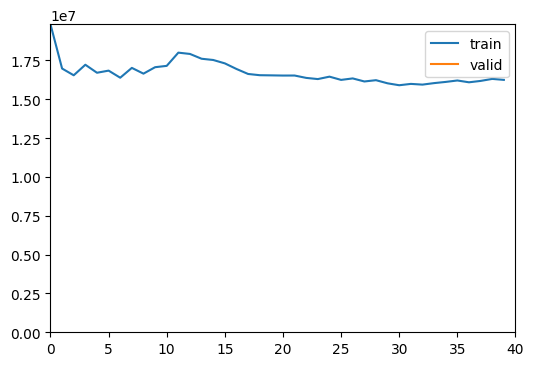

epoch,train_loss,valid_loss,time
0,16527447.000000,17582240.000000,00:14
1,16272714.000000,17582456.000000,00:15
2,16272368.000000,17581118.000000,00:15
3,16273310.000000,17581308.000000,00:15
4,16295401.000000,17577036.000000,00:15
5,16381635.000000,17575526.000000,00:15
6,16287027.000000,17572602.000000,00:15
7,16200646.000000,17565614.000000,00:15
8,16267252.000000,17559210.000000,00:15
9,16293584.000000,17549168.000000,00:15


Better model found at epoch 0 with valid_loss value: 17582240.0.


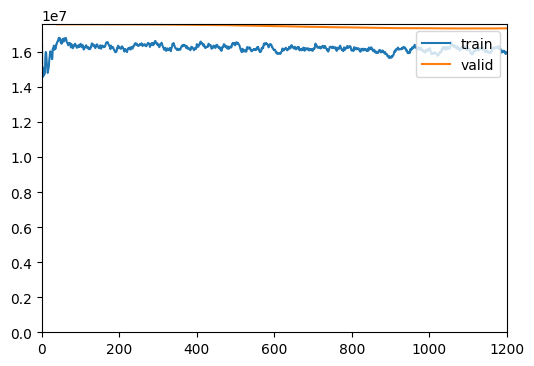

Epoch 1: reducing lr to 1.4567507511724669e-05
Better model found at epoch 2 with valid_loss value: 17581118.0.
Epoch 3: reducing lr to 2.6355287403487125e-05
Better model found at epoch 4 with valid_loss value: 17577036.0.
Better model found at epoch 5 with valid_loss value: 17575526.0.
Better model found at epoch 6 with valid_loss value: 17572602.0.
Better model found at epoch 7 with valid_loss value: 17565614.0.
Better model found at epoch 8 with valid_loss value: 17559210.0.
Better model found at epoch 9 with valid_loss value: 17549168.0.
Better model found at epoch 10 with valid_loss value: 17540260.0.
Better model found at epoch 11 with valid_loss value: 17530142.0.
Better model found at epoch 12 with valid_loss value: 17510842.0.
Better model found at epoch 13 with valid_loss value: 17497204.0.
Better model found at epoch 14 with valid_loss value: 17478054.0.
Better model found at epoch 15 with valid_loss value: 17464012.0.
Better model found at epoch 16 with valid_loss value: 1

In [17]:
learn.fine_tune(30,base_lr=1e-3)

In [18]:
dls = db.dataloaders(df,bs=4)

In [19]:
learn.dls=dls

In [20]:
preds,gt = learn.get_preds()

/tmp/ipykernel_2051330/3432634807.py:7: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  res = self.func2(ys[0],torch.reshape(xs[0],(4,1)))
/tmp/ipykernel_2051330/3432634807.py:9: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  res = res + self.func2(ys[i],torch.reshape(xs[i],(4,1)))
/tmp/ipykernel_2051330/3432634807.py:10: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  res = res + self.func2(ys[10],torch.reshape(xs[10],(4,1)))


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [22]:
gt[-1]

tensor([ 2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,
         2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,
        11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500,
        11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500,
         1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,
         1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,
         7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,
         7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500])

In [23]:
preds[-1]

tensor([[18.7213],
        [19.3824],
        [19.3798],
        [19.0841],
        [20.1780],
        [20.0318],
        [20.2852],
        [20.0583],
        [20.0264],
        [19.3986],
        [19.4502],
        [17.6737],
        [20.4568],
        [21.1785],
        [22.1032],
        [20.2319],
        [20.7209],
        [20.4900],
        [20.5959],
        [20.4331],
        [19.2960],
        [19.9897],
        [18.5359],
        [19.2931],
        [19.9083],
        [21.7227],
        [20.9426],
        [20.2464],
        [19.9766],
        [20.7050],
        [19.8457],
        [21.0014],
        [18.6600],
        [19.0773],
        [19.0390],
        [18.9322],
        [20.5353],
        [19.8860],
        [20.0806],
        [20.2583],
        [20.6060],
        [19.1843],
        [21.5548],
        [20.0576],
        [20.9897],
        [19.4451],
        [20.6888],
        [20.3664],
        [20.6096],
        [20.6796],
        [19.5879],
        [21.3692],
        [17.

In [24]:
mean_absolute_error(gt[-1],preds[-1])

14.225684

In [25]:
mean_squared_error(gt[-1],preds[-1])

217.75815

In [26]:
math.sqrt(mean_squared_error(gt[-1],preds[-1]))

14.75663065179038